In [1]:
%matplotlib inline

# Beta Distributions per Annotation 

<big>This notebook includes code and instructions to re-generate figures included in the Data Descriptor article for the CNeuroMod-THINGS dataset. These figures feature beta weight distributions split per annotation seen in **Figure 7**, along with mosaics of the stimulus images that received the highest beta scores in a given ROI.</big>

### Note:
Due to copyrights, the stimulus images featured in the paper's Figure 7 are CC0 look-alikes. By contrast, the images that compose the mosaics generated with the current Notebook are the original images (from the THINGS image set) shown to participants inside the scanner. 

<br/>

---


# 0 | Installation

### Note:
If you are following these instructiuons on Github, we recommend that you view this Notebook through [https://nbviewer.org](https://nbviewer.org/github/courtois-neuromod/cneuromod-things/blob/main/datapaper/notebooks/annotated_betas_per_ROI.ipynb) for a more accurate rendering and improved readability. 

### 0.1 | Install required Python libraries
To run this Notebook and re-create figures, you need to install the following Python libraries (e.g., inside a virtual environment). 

```shell
jupyter==1.0.0
numpy==1.24.4
pandas==1.3.5
matplotlib==3.7.5
ptitprince==0.2.5
pillow==9.0.1
seaborn==0.11.2
```
<br/>

---

### 0.2 | Install the CNeuroMod-THINGS dataset

To generate figures, you need to download a few files from the CNeuroMod-THINGS dataset. 

Use the DataLad software (version > 1.0.0, https://www.datalad.org/) to clone the `cneuromod-things` repository. 
DataLad is a versionning tool to manage large data structures organized in git repositories available for Linux, OSX and Windows. 

Note: the command below installs **symbolic links without downloading heavy files** onto your local machine.

```bash
datalad clone git@github.com:courtois-neuromod/cneuromod-things.git
```
<br/>

---


### 0.3 | Pull the files needed to generate figures

Before you can run this Notebook, you need to **download a few input files** onto your local machine. 

Inside the newly cloned `cneuromod-things` repository, first navigate to `cneuromod-things/THINGS/glmsingle`, which is a submodule inside the main repository. Upon installation, the `glmsingle` submodule will appear empty. 

```bash
cd cneuromod-things/THINGS/glmsingle
ls
```
<br/>

Use DataLad to download the `glmsingle` submodule's symbolic links and files stored directly on Github (**no large files will be pulled**).

```bash
datalad get *
ls
```
<br/>

Make sure that the file `task-things_imgAnnotations.json` is listed in the `glmsingle` submodule. 

Finally, use DataLad to download the files that contain the trial labels, beta weights and noise ceilings (for thresholding) onto your local machine (pulled from remote server via symbolic links).

```bash
datalad get sub-*/descriptive/sub-*_task-things_space-T1w_contrast-*_roi-*_stat-betas_desc-*_statseries.npy
datalad get sub-*/descriptive/sub-*_task-things_desc-*_labels.npy
datalad get sub-*/descriptive/sub-*_task-things_space-T1w_contrast-*_roi-*_stat-noiseCeilings_desc-*_statseries.npy
```
<br/>



---

### 0.4 | Pull and unzip the THINGS image stimuli

#### This step is optional: 
If you wish to create **mosaics of stimulus images** that received the highest beta scores for a given ROI, you need to pull and unzip the **THINGS image stimuli** (images_fmri.zip) directly onto your local machine. The images are stored in a structure of nested submodules.

From the main repository, navigate to the `cneuromod-things/THINGS/fmriprep` submodule, and use DataLad to pull its symbolic links. 

```bash
cd cneuromod-things/THINGS/fmriprep
datalad get *                # Downloads symbolic links
```
<br/>

Next, navigate to the `cneuromod-things/THINGS/fmriprep/sourcedata/things` sub-submodule, and pull its symbolic links. 

```bash
cd sourcedata/things
datalad get *                # Downloads symbolic links
```
<br/>

Finally, navigate to the `cneuromod-things/THINGS/fmriprep/sourcedata/things/stimuli` sub-sub-submodule, pull its symbolic links, and download the stimulus images. 

```bash
cd stimuli
datalad get *                # Downloads symbolic links
datalad get images_fmri.zip  # Pull images locally
```
<br/>


Stimulus images are stored in `images_fmri.zip`. To access the images, unzip `images_fmri.zip`. You will be prompted for a password provided inside the `password_images.txt` file. By using this password, you confirm that you agree **to use the images only for research and non-commercial purposes**, and you agree **not to distribute or alter them without permission from the owner(s) of the images.**
```bash
unzip images_fmri
Archive:  images_fmri.zip
[images_fmri.zip] images_fmri/acorn/acorn_01b.jpg password:
```
<br/>


---
### 0.4 | Launch the Jupyter Notebook

Inside `cneuromod-things`, navigate to the tutorial section, and open the current Jupyter Notebook (annotated_betas_per_ROI.ipynb)
```bash
cd cneuromod-things/datapaper/notebooks
jupyter notebook
```
<br/>

---
# 1 | Import Python libraries

Run the code below to import Python libraries.

In [2]:
import os, glob, json
from pathlib import Path

import numpy as np
from numpy import nan as NaN
import pandas as pd
import seaborn as sns
import ptitprince as pt
import matplotlib.pyplot as plt 

from PIL import Image
from matplotlib.pyplot import imshow

import matplotlib
print('matplotlib version: ', matplotlib.__version__)
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
import PIL
print('Pillow version: ', PIL.__version__)
print('ptitprince version: ', '0.2.5')
print('seaborn version: ', sns.__version__)

matplotlib version:  3.7.5
numpy version:  1.24.4
pandas version:  1.3.5
Pillow version:  9.0.1
ptitprince version:  0.2.5
seaborn version:  0.11.2


---

# 2 | Define support functions

Run the code below to define support functions to build a DataFrame of image labels

In [3]:
"""
Define support functions
"""
def cap_vals(row, value, cap):
    if row[value] > cap:
        return cap
    else:
        return row[value]
    
    
def label_cft(row):
    grp_val = row['cfpt']
    if grp_val == 3:
        return '1. human face'
    elif grp_val == 2:
        return '2. mammal face'
    elif grp_val == 1:
        return '3. other face'
    elif grp_val == 0:
        return '4. no face'

    
def label_clt(row):
    grp_val = row['clpt']
    if grp_val >= 3:
        return '1. human'
    elif grp_val == 2:
        return '2. mammal'
    elif grp_val == 1:
        return '3. other living thing'
    elif grp_val == 0:
        return '4. no living thing'

    
def label_cbt(row):
    grp_val = row['cbpt']
    if grp_val >= 3:
        return '1. human body'
    elif grp_val == 2:
        return '2. mammal body'
    elif grp_val == 1:
        return '3. other living body'
    elif grp_val == 0:
        return '4. no living body'

    
def label_bkpt(row):
    grp_val = row['bkpt']
    if grp_val >= 3:
        return '1. scene'
    elif grp_val == 2:
        return '2. rich background'
    elif grp_val == 1:
        return '3. minimum background'
    elif grp_val == 0:
        return '4. no background'
    
    
def label_rf(row):
    grp_val = row['chfrf']
    if grp_val == 2:
        return '1. natural human face'
    elif grp_val == 1:
        return '2. artificial human face'
    elif grp_val == 0:
        return '3. no human face'
    

def generate_data(
    beta_idx: np.array,
    img_idx: np.array,
    ranked_betas: np.array,
    img_details: dict,
) -> pd.DataFrame:
    """
    Builds DataFrame of betas, image labels and annotations to plot ranked betas
    """
    df_2plot = pd.DataFrame(ranked_betas, columns=['betas'])

    """
    Face stuff
    """
    is_face = np.array([img_details[img_idx[x]]['manual_face'] for x in beta_idx])
    is_human_face = np.array([img_details[img_idx[x]]['manual_human_face'] for x in beta_idx])
    is_nh_mammal_face = np.array([img_details[img_idx[x]]['manual_nh_mammal_face'] for x in beta_idx])
    is_central_face = np.array([img_details[img_idx[x]]['manual_central_face'] for x in beta_idx])
    is_artificial_face = np.array([img_details[img_idx[x]]['manual_artificial_face'] for x in beta_idx])

    df_2plot['is_face'] = is_face.astype(bool)
    df_2plot['is_central_face'] = is_central_face.astype(bool)
    df_2plot['is_noncentral_face'] = (is_face*(is_central_face==0)).astype(bool)
    df_2plot['is_human_face'] = is_human_face.astype(bool)
    df_2plot['is_central_human_face'] = (is_human_face*is_central_face).astype(bool)
    df_2plot['is_noncentral_human_face'] = (is_human_face*(is_central_face==0)).astype(bool)
    df_2plot['is_central_mammal_face'] = ((is_human_face*is_central_face)+(is_nh_mammal_face*is_central_face)).astype(bool)

    # levels: central face that is human (3), nh_mammal (2), or something else (1)
    df_2plot['cfpt'] = (is_central_face + (2*(is_central_face*is_human_face)) + (is_central_face*is_nh_mammal_face)).astype(int)
    df_2plot['cfpt'] = df_2plot.apply(lambda row: cap_vals(row, 'cfpt', 3), axis=1)
    df_2plot['central_face_per_type'] = df_2plot.apply(lambda row: label_cft(row), axis=1)

    # levels: central human face that is natural (2) or artificial (1)
    df_2plot['chfrf'] = (((is_human_face*is_central_face)*2) - (is_human_face*is_central_face*is_artificial_face)).astype(int)
    df_2plot['chfrf'] = df_2plot.apply(lambda row: cap_vals(row, 'chfrf', 3), axis=1)
    df_2plot['central_human_face_realORfake'] = df_2plot.apply(lambda row: label_rf(row), axis=1)

    
    """
    Body stuff
    """
    has_body = np.array([img_details[img_idx[x]]['manual_body'] for x in beta_idx])
    has_human_body = np.array([img_details[img_idx[x]]['manual_human_body'] for x in beta_idx])
    has_nh_mammal_body = np.array([img_details[img_idx[x]]['manual_nh_mammal_body'] for x in beta_idx])
    has_central_body = np.array([img_details[img_idx[x]]['manual_central_body'] for x in beta_idx])
    has_artificial_body = np.array([img_details[img_idx[x]]['manual_artificial_body'] for x in beta_idx])

    df_2plot['has_body'] = has_body.astype(bool)
    df_2plot['has_central_body'] = has_central_body.astype(bool)
    df_2plot['has_human_body'] = has_human_body.astype(bool)
    df_2plot['has_central_human_body'] = (has_human_body*has_central_body).astype(bool)

    df_2plot['has_living'] = (has_body + is_face).astype(bool)
    df_2plot['has_central_living'] = ((has_body*has_central_body) + (is_face*is_central_face)).astype(bool)

    # levels: central living (body or face): human (3), nh_mammal (2) or something else (1)
    centr_human = ((has_human_body*has_central_body) + (is_human_face*is_central_face)).astype(bool)
    centr_mammal = ((has_nh_mammal_body*has_central_body) + (is_nh_mammal_face*is_central_face)).astype(bool)
    df_2plot['clpt'] = (df_2plot['has_central_living'].to_numpy() + (2*centr_human) + centr_mammal).astype(int)
    df_2plot['clpt'] = df_2plot.apply(lambda row: cap_vals(row, 'clpt', 3), axis=1)
    df_2plot['central_living_per_type'] = df_2plot.apply(lambda row: label_clt(row), axis=1)

    # levels: central body: human (3), nh_mammal (2) or something else (1)
    df_2plot['cbpt'] = (has_central_body + (2*(has_central_body*has_human_body)) + (has_central_body*has_nh_mammal_body)).astype(int)
    df_2plot['cbpt'] = df_2plot.apply(lambda row: cap_vals(row, 'cbpt', 3), axis=1)
    df_2plot['central_body_per_type'] = df_2plot.apply(lambda row: label_cbt(row), axis=1)

    
    """
    Scene stuff
    """    
    is_lone_object = np.array([img_details[img_idx[x]]['manual_lone_object'] for x in beta_idx])
    is_scene = np.array([img_details[img_idx[x]]['manual_scene'] for x in beta_idx])
    had_bcground = np.array([img_details[img_idx[x]]['manual_rich_background'] for x in beta_idx])

    df_2plot['is_scene'] = is_scene.astype(bool)
    df_2plot['has_bckground'] = had_bcground.astype(bool)
    df_2plot['background_or_scene'] = (had_bcground + is_scene).astype(bool)

    # levels: is lone object (0), object (1), bckground (2) or scene (3)
    df_2plot['bkpt'] = (np.ones(df_2plot.shape[0]) + had_bcground + 2*(is_scene) - is_lone_object).astype(int)
    df_2plot['bkpt'] = df_2plot.apply(lambda row: cap_vals(row, 'bkpt', 3), axis=1)
    df_2plot['background_per_type'] = df_2plot.apply(lambda row: label_bkpt(row), axis=1)

    df_2plot['rank'] = np.array(df_2plot.index + 1).astype(int)

    return df_2plot


---
# 3 | Plot Beta Distributions and Top Images (Figure 7)

**Fig. 7** features distributions of beta weights per image split according to image annotations.

**Extra (optional)**: mosaic of stimulus images with top beta scores within a given ROI.

**Input files**: 
* cneuromod-things/THINGS/glmsingle/task-things_imgAnnotations.json
* cneuromod-things/THINGS/glmsingle/sub-{s_num}/descriptive/sub-{s_num}_task-things_space-T1w_contrast-{face, scene, body}_roi-{...}_stat-betas_desc-{perImage, perTrial}_statseries.npy
* cneuromod-things/THINGS/glmsingle/sub-{s_num}/descriptive/sub-{s_num}_task-things_desc-{perImage, perTrial}_labels.npy
* neuromod-things/THINGS/glmsingle/sub-{s_num}/descriptive/sub-{s_num}_task-things_space-T1w_contrast-{face, scene, body}_roi-{...}_stat-noiseCeilings_desc-{perImage, perTrial}_statseries.npy
* (**optional**) cneuromod-things/THINGS/fmriprep/sourcedata/things/stimuli/images_fmri
 


### 3.1 | Set paths and variables


In [4]:
"""
Adjust the variables below, then run this cell
"""

#################################
# set save_fig to True to export 
# .png files of Fig. 7 / image mosaic
#################################
save_fig = False


#################################
# Set create_mosaic to True to generate 
# a mosaic from stimulus images with top
# beta weights in ROI.

# NOTE: REQUIRES downloading the THINGS
# image set
#################################
create_mosaic = True


##################################################
# Select subject number: "01", "02", "03" or "06"
##################################################
s = "03"


##################################################
# Select which ROI betas to plot

# ROI Choices:
# 'face_roi-FFA':      fusiform face area (FFA)
# 'body_roi-EBA':      extrastriate body area (EBA)
# 'scene_roi-PPA':     parahippocampal place area (PPA)
##################################################
roi = 'face_roi-FFA'  


####################
# If top_voxel = True, plots beta scores from the
# ROI's single voxel with the highest noise ceiling.
# If False, averages beta scores across the 
# 50 ROI voxels with the highest noise ceilings.

# Set to True in the datapaper.
####################
top_voxel = True


####################
# If per_image = True, plots beta scores averaged
# per image (over 3 repetitions). Excludes images 
# with no registered answer and images with fewer than 3 repetitions. 

# If False, plots trial-wise betas (excluding 
# trials with no registered answers).

# Set to True in the datapaper.
####################
per_image = True



################################################################################
# Resolve relative paths (nothing to change below this point)

data_file_path = Path("../../THINGS/glmsingle").resolve()
stimuli_path = Path("../../THINGS/fmriprep/sourcedata/things/stimuli/images_fmri").resolve()

fig_save_path = Path("../figures").resolve()

# Load image labels and annotations
with open(f"{data_file_path}/task-things_imgAnnotations.json", "r") as f:
    image_details = json.load(f)


### 3.2 | Run the code below to generate Fig. 7 (and bonus mosaic)

Generate beta weight distributions per ROI split according to annotations

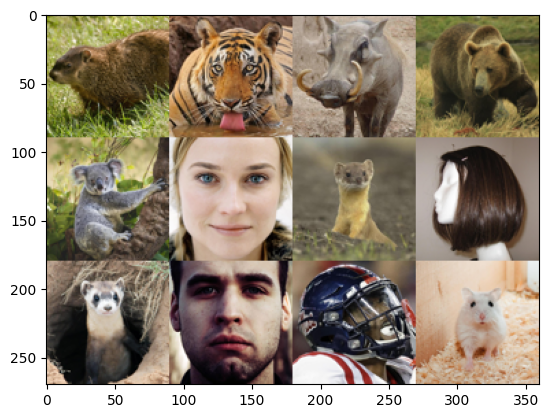

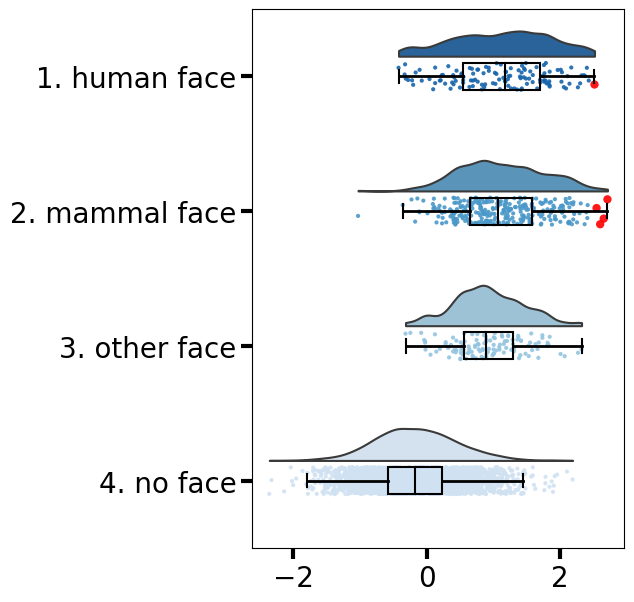

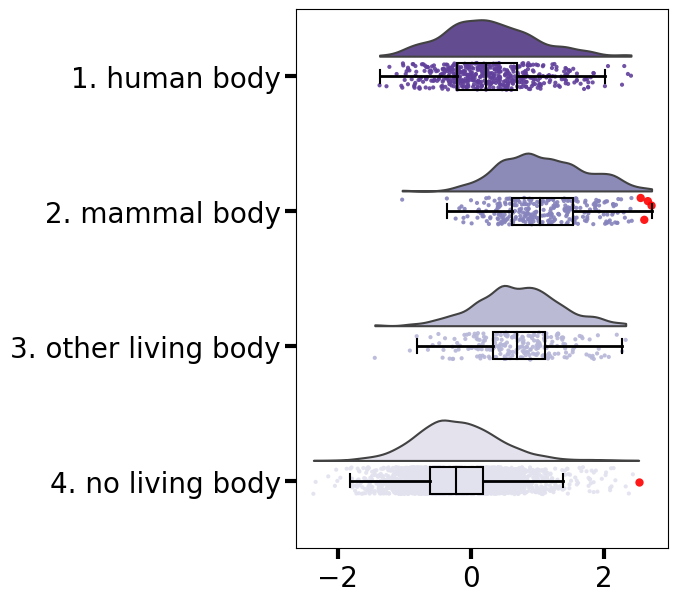

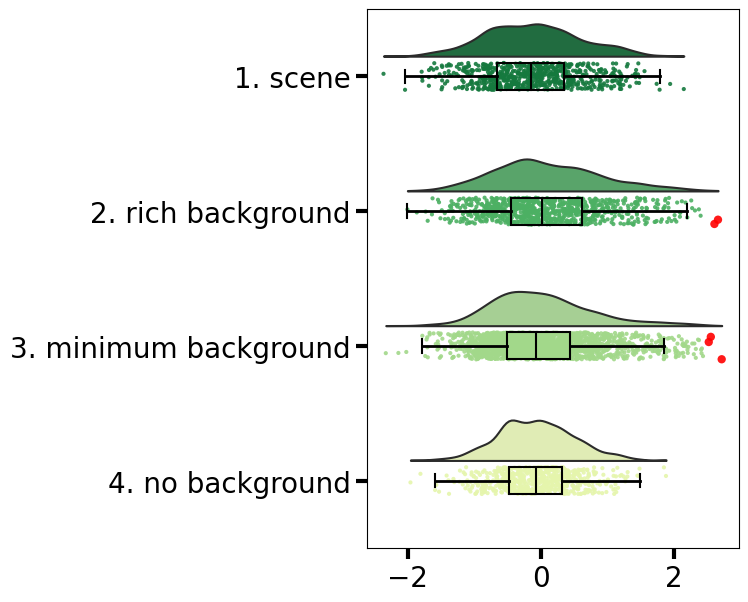

In [5]:

"""
Load files
"""
desc = "perImage" if per_image else "perTrial"

betas = np.load(
    glob.glob(
        f"{data_file_path}/sub-{s}/descriptive/sub-{s}_task-things_space-T1w_contrast-{roi}_*"
        f"_stat-betas_desc-{desc}_statseries.npy"
    )[0], allow_pickle=True)

imgIdx = np.load(
    f"{data_file_path}/sub-{s}/descriptive/sub-{s}_task-things_desc-{desc}_labels.npy",
    allow_pickle=True)

noiseCeil = np.load(
    glob.glob(
        f"{data_file_path}/sub-{s}/descriptive/sub-{s}_task-things_space-T1w_contrast-{roi}_*"
        f"_stat-noiseCeilings_desc-{desc}_statseries.npy"
    )[0], allow_pickle=True)


"""
Select the betas
"""
if top_voxel:
    """
    Select betas from single voxel with highest noise ceiling within ROI mask
    """    
    # get top voxel's betas
    top_idx = np.argmax(noiseCeil)
    select_betas = betas[:, top_idx] 
    nvox = "nvox-1"

else:
    """
    Average betas from all (n<=50) ROI voxels and plot mean betas
    """    
    select_betas = np.mean(betas, axis=1)
    nvox = f"nvox-{betas.shape[1]}"


"""
Sort the selected betas from largest to smallest
"""
betas_idx = np.argsort(select_betas, axis=0)[::-1]  
ranked_betas = select_betas[betas_idx]    


"""
Get image annotations corresponding to the beta scores into a dataframe
"""
df_annotations = generate_data(betas_idx, imgIdx, ranked_betas, image_details)



"""
Create a mosaic from the 12 images with the highest beta scores in the chosen ROI
"""

if create_mosaic:
    SMALL_SIZE = 10
    BIGGER_SIZE = 20
    
    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
    
    
    num_pics = 12
    pic_list = [imgIdx[x] for x in betas_idx[:num_pics].tolist()]
    
    tile_size = (900, 900) if save_fig else (90, 90)
    mosaic_size = (3600, 2700) if save_fig else (360, 270)
    width = 4
    height = 3
    
    tiles = [
        Image.open(
            f"{stimuli_path}/{x.split('_0')[0]}/{x}.jpg"
        ).resize(tile_size) for x in pic_list
    ]
    
    mosaic = Image.new('RGB', mosaic_size)
    pic_idx = 0
    
    for i in range(width):
        for j in range(height):
            if pic_idx < num_pics:
                x, y = i*tile_size[0], j*tile_size[1]
                mosaic.paste(tiles[pic_idx], (x, y))
                pic_idx += 1
    
    if save_fig:
        rname = roi.split('_')[-1]
        Path(f"{fig_save_path}/beta_dist").mkdir(parents=True, exist_ok=True)
        mosaic.save(
            f'{fig_save_path}/beta_dist/sub-{s}_{rname}_{nvox}_{desc}_moisaic.jpg'
        )
        
    imshow(mosaic)
    plt.show()


"""
Generate swarm + violin plot figure of beta scores split into separate distribution according to 
their annotations

Annotations include: the presence and type of face, the presence and type of body part, 
and the kind of background in which an object is set
"""

for annotation in [
    ("central_face_per_type", "annot-faceType", "Blues_r"),
    ("central_body_per_type", "annot-bodyType", "Purples_r"),
    ("background_per_type", "annot-sceneType", "YlGn_r")
]: 

    SMALL_SIZE = 8
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 30

    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    df = df_annotations

    f, ax = plt.subplots(figsize=(4.8, 7))

    dy=annotation[0]; dx="betas"; ort="h"; 
    cat_order = sorted(np.unique(df[annotation[0]]).tolist())

    pal = sns.color_palette(annotation[2], 4)

    ax=pt.half_violinplot(x = dx, y = dy, data = df, palette = pal, bw = .2, cut = 0.,
                          scale = "area", width = .6, inner = None, orient = ort, order=cat_order)
    ax=sns.stripplot(x = dx, y = dy, data = df.iloc[5:, :], palette = pal, edgecolor = "white",
                     size = 3, alpha=0.90, s=3, jitter = 1, zorder = 0, orient = ort, order=cat_order)

    ax=sns.stripplot(x = dx, y = dy, data = df.iloc[:5, :], color = "red", edgecolor = "white",
                     size = 3, alpha=0.90, s=6, jitter = 1, zorder = 0, orient = ort, order=cat_order)

    ax=sns.boxplot(x = dx, y = dy, data = df, color = "black", width = .20, zorder = 10, 
                   showcaps = True, boxprops = {'facecolor':'none', "zorder":10},
                   showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},
                   saturation = 1, orient = ort, order=cat_order)

    ax.tick_params(width=3, size=8)

    plt.xticks([-2, 0, 2])
    plt.xlabel('')
    plt.ylabel('')

    if save_fig:

        plt.savefig(f"{fig_save_path}/beta_dist/Fig5_sub-{s}_betas_{roi.split('_')[-1]}_{nvox}_desc-{desc}_{annotation[1]}.png", dpi=600, bbox_inches='tight')
    plt.plot()

    
    
    